<a href="https://colab.research.google.com/github/danielegenta/Progetto-MLDL/blob/master/main_icarl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
"""
  Following the iCaRL paper specifications.
  ...documentation ...
"""

'\n  Following the iCaRL paper specifications.\n  ...documentation ...\n'

In [0]:
"""!pip3 install 'torch==1.3.1'
!pip3 install 'torchvision==0.5.0'
!pip3 install 'Pillow-SIMD'
!pip3 install 'tqdm'"""
# !pip install --upgrade wandb

"!pip3 install 'torch==1.3.1'\n!pip3 install 'torchvision==0.5.0'\n!pip3 install 'Pillow-SIMD'\n!pip3 install 'tqdm'"

In [0]:
import os
import logging

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Subset, DataLoader
from torch.backends import cudnn

import torchvision
from torchvision import transforms

from PIL import Image
from tqdm import tqdm
import random


import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import time

from sklearn.metrics import confusion_matrix
import math

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
DATA_DIR = 'DATA' # here the dataset will be downloaded

# Clone github repository with dataset handler
!rm -r Cifar100/
!rm -r $DATA_DIR
!mkdir "DATA"
if not os.path.isdir('./Cifar100'):
  !git clone https://github.com/danielegenta/Progetto-MLDL.git
  !mv 'Progetto-MLDL' 'Cifar100'
  !rm -r Cifar100/Theoretical-Sources
  !rm -rf Cifar100/ProjectMLDL.ipynb

Cloning into 'Progetto-MLDL'...
remote: Enumerating objects: 76, done.
remote: Counting objects: 100% (76/76), done.
remote: Compressing objects: 100% (56/56), done.
remote: Total 1517 (delta 40), reused 54 (delta 20), pack-reused 1441
Receiving objects: 100% (1517/1517), 7.43 MiB | 35.38 MiB/s, done.
Resolving deltas: 100% (931/931), done.


dataset

In [0]:
# Download dataset from the official source and save it into DATA/cifar-100-pyhton

if not os.path.isdir('./{}'.format("$DATA_DIR/cifar-100-python")):
    !wget https://www.cs.toronto.edu/~kriz/cifar-100-python.tar.gz
    !tar -xf 'cifar-100-python.tar.gz'  
    !mkdir $DATA_DIR
    !mv 'cifar-100-python' "$DATA_DIR/cifar-100-python"
    !rm -rf 'cifar-100-python.tar.gz

--2020-05-30 17:18:24--  https://www.cs.toronto.edu/~kriz/cifar-100-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 169001437 (161M) [application/x-gzip]
Saving to: ‘cifar-100-python.tar.gz’

cifar-100-python.ta 100%[===================>] 161.17M  50.0MB/s    in 3.6s    

2020-05-30 17:18:28 (45.0 MB/s) - ‘cifar-100-python.tar.gz’ saved [169001437/169001437]

mkdir: cannot create directory ‘DATA’: File exists
/bin/bash: -c: line 0: unexpected EOF while looking for matching `''
/bin/bash: -c: line 1: syntax error: unexpected end of file


In [0]:
from Cifar100 import utils


dictHyperparams = utils.getHyperparams()
print(dictHyperparams)

DEVICE = dictHyperparams["DEVICE"] # 'cuda' or 'cpu'
NUM_CLASSES = dictHyperparams["NUM_CLASSES"] 

BATCH_SIZE = dictHyperparams["BATCH_SIZE"]     # Higher batch sizes allows for larger learning rates. An empirical heuristic suggests that, when changing
                     # the batch size, learning rate should change by the same factor to have comparable results

LR = dictHyperparams["LR"]          # The initial Learning Rate
MOMENTUM = dictHyperparams["MOMENTUM"]       # Hyperparameter for SGD, keep this at 0.9 when using SGD
WEIGHT_DECAY = dictHyperparams["WEIGHT_DECAY"] # Regularization, you can keep this at the default

NUM_EPOCHS = dictHyperparams["NUM_EPOCHS"]     # Total number of training epochs (iterations over dataset)
GAMMA = dictHyperparams["GAMMA"]         # Multiplicative factor for learning rate step-down

LOG_FREQUENCY = dictHyperparams["LOG_FREQUENCY"]
MILESTONES = dictHyperparams["MILESTONES"]
RANDOM_SEED = dictHyperparams["SEED"]

# icarl params
herding = True # if false random exemplars, if true nme (herding)
classifier = "NCM" # NCM, FCC ...

{'LR': 2, 'MOMENTUM': 0.9, 'WEIGHT_DECAY': 1e-05, 'NUM_EPOCHS': 70, 'MILESTONES': [49, 63], 'BATCH_SIZE': 128, 'DEVICE': 'cuda', 'GAMMA': 0.2, 'SEED': 88, 'LOG_FREQUENCY': 10, 'NUM_CLASSES': 100}


In [0]:
train_transform, eval_transform = utils.getTransformations()

In [0]:
from Cifar100.Dataset.cifar100 import CIFAR100

# Import dataset
train_dataset = CIFAR100(DATA_DIR, split='train', transform=train_transform)
test_dataset = CIFAR100(DATA_DIR, split='test', transform=eval_transform)

# check if datasets have been correctly loaded
print(len(train_dataset))
print(len(test_dataset))

50000
10000


In [0]:
from Cifar100.reverse_index import ReverseIndex

def build_test_splits(dataset, reverse_index):
    splits = dict()
    groups = list(reverse_index.getGroups())
    for g in groups:
        labels_of_groups = reverse_index.getLabelsOfGroup(g)
        indices = list(dataset.df[dataset.df['labels'].isin(labels_of_groups)].index)
        splits[g] = indices
    return splits

In [0]:
# performing the train/val split
train_splits = train_dataset.split_in_train_val_groups(ratio=1, seed=RANDOM_SEED)
outputs_labels_mapping = ReverseIndex(train_dataset, train_splits)

# performing the test split (coherent with train/val)
test_splits = build_test_splits(test_dataset, outputs_labels_mapping)

In [0]:
# Dataloaders iterate over pytorch datasets and transparently provide useful functions (e.g. parallelization and shuffling)
train_subsets = []
val_subsets = []
test_subsets = []

for v in train_splits.values():
    train_subs = Subset(train_dataset, v['train'])
    #val_subs = Subset(train_dataset, v['val'])
    train_subsets.append(train_subs)
    #val_subsets.append(val_subs)

for i in range(0,10): # for each group of classes
    v=test_splits[i]
    test_subs = Subset(test_dataset, v)
    test_subsets.append(test_subs)

**Exemplars management**<br>
From iCaRL. We have an exemplar set for each class that we have seen so far. The cardinality of each exemplar set is constant and it is equal, at any time, to m = K/t. Where K is a constraint equal to the amount of memory we're allocating for the exemplars and t is the number of classes that has been seen so far. Implementing iCaRL, whenever a group of (10) classes is trained, it is trained on the train data for those classes (as before) + the current exemplars sets.*italicized text*

In [0]:
from Cifar100.icarl_model import ICaRL

# default params

K = 2000
n_classes = 0
feature_size = 2048

icarl = ICaRL(feature_size, n_classes, BATCH_SIZE, WEIGHT_DECAY, LR, GAMMA, NUM_EPOCHS, DEVICE,MILESTONES,MOMENTUM, K, herding, outputs_labels_mapping)
icarl.cuda() 

ICaRL(
  (net): ResNet(
    (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(16, 16, kernel_size=

In [0]:
def computeAccuracy(method, net, loader, reverse_index, dataset, all_preds_cm, all_labels_cm):
  total = 0.0
  correct = 0.0
  for indices, images, labels in loader:
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)
        labels = reverse_index.getNodes(labels)
        
        # add other classifiers
        if classifier == 'NCM':
          preds = net.classify(images)
        elif classifier == 'FCC':
          preds = net.FCC_classify(images)

        correct += torch.sum(preds == labels.data).data.item()
  accuracy = correct/len(dataset)
  if method == 'test':
    all_preds_cm.extend(preds.tolist())
    all_labels_cm.extend(labels.data.tolist())
  return accuracy, all_preds_cm, all_labels_cm

In [0]:
def incrementalTraining(icarl, train_subsets, val_subsets, test_subsets,eval_transform, reverse_index, K):
    
    all_accuracies = []
    all_preds_cm = []
    all_labels_cm = []
    group_id=1
    test_set = None
    train_set_big = None # train subsets so far (needed for exemplars)

    #for train_subset, val_subset, test_subset in zip(train_subsets, val_subsets, test_subsets):
    for train_subset, test_subset in zip(train_subsets, test_subsets):
        print("GROUP: ",group_id)
        if test_set is None:
          test_set = test_subset
          train_set_big = train_subset
        else:
          test_set = utils.joinSubsets(test_dataset, [test_set, test_subset])
          train_set_big = utils.joinSubsets(train_dataset, [train_set_big, train_subset])

        train_dataloader = DataLoader(train_subset, batch_size=BATCH_SIZE,shuffle=True, num_workers=4)
        #val_dataloader = DataLoader(val_subset, batch_size=BATCH_SIZE,shuffle=True, num_workers=4)
        test_dataloader = DataLoader(test_set, batch_size=BATCH_SIZE,shuffle=True, num_workers=4)

        ####### iCaRL implementation(following alg. 2,3,4,5 on icarl paper) ##################
        
        new_classes_examined = list(train_dataset.df.loc[train_subset.indices, 'labels'].value_counts().index)
        
        # 1 - update representation of the net 
        #  alg. 3 icarl
        # (here the trainset will be augmented with the exemplars too)
        # (here the classes are incremented too)
        icarl.update_representation(train_subset, train_dataset, new_classes_examined)

        # 2 - update m (number of images per class in the exemplar set corresponding to that class)
        m = int(math.ceil(K/icarl.n_classes))

        print("Reducing each exemplar set to size: {}".format(m))

        # 3 - reduce exemplar set for all the previously seen classes
        # alg.5 icarl
        icarl.reduce_exemplar_sets(m)

        # retrieve the 10 classes in the current subset
        # NB. Here there will be exemplars too! (if i do not want that, use new_classes_examined)
        classes_current_subset = list(train_dataset.df.loc[train_subset.indices, 'labels'].value_counts().index)
        
        print("Constructing exemplar sets class...")
        
        # 4 - construct the exemplar set for the new classes
        for y in new_classes_examined: # for each class in the current subset
          
          
          # extract all the imgs in the train subset that are linked to this class
          images_current_class = train_subset.dataset.df.loc[train_dataset.df['labels'] == y, 'data'] #they're TENSORS NOT IMAGES (the conversion will be done later)         
          imgs_idxs = images_current_class.index # the indexes of all the images in the current classe being considered 0...49k
          class_train_subset = Subset(train_dataset, imgs_idxs)#subset of the train dataset where i have all the imgs of class y

          # alg. 4 icarl
          #print(type(class_train_subset))
          icarl.construct_exemplar_set(class_train_subset,m,y) # why eval? ref: https://github.com/donlee90/icarl/blob/master/main.py

        # update the num classes seen so far
        icarl.n_known = icarl.n_classes #n_classes is incremented in 1: updateRepresentation

        print("Performing classification...")

        # start classifier ...
        icarl.computeMeans()
        
        #train accuracy
        train_accuracy, _, _ = computeAccuracy('train',icarl, train_dataloader, reverse_index, train_subset,all_preds_cm, all_labels_cm)
        print ('Train Accuracy (on current group): %.2f\n' % (100.0 * train_accuracy))

        # --- not used
        #val_accuracy, _, _ = computeAccuracy('val',icarl, val_dataloader, reverse_index, val_subset)
        #print ('Val Accuracy (on current group): %.2f\n' % (100.0 * val_accuracy))

        #test
        test_accuracy, all_preds_cm, all_labels_cm = computeAccuracy('test',icarl, test_dataloader, reverse_index, test_set, all_preds_cm, all_labels_cm)
        all_accuracies.append(test_accuracy)
        print ('Test Accuracy (all groups seen so far): %.2f\n' % (100.0 * test_accuracy))

        print ("the model knows %d classes:\n " % icarl.n_known)

        group_id+=1
        
    return all_accuracies, np.array(all_preds_cm), np.array(all_labels_cm)

In [0]:
accuracies, all_preds_cm, all_labels_cm = incrementalTraining(icarl, train_subsets, val_subsets, test_subsets,eval_transform, outputs_labels_mapping, K)

GROUP:  1
NUM_EPOCHS:  0 / 70
LOSS:  0.33419695496559143
NUM_EPOCHS:  1 / 70
LOSS:  0.32229432463645935
NUM_EPOCHS:  2 / 70
LOSS:  0.3151329457759857
NUM_EPOCHS:  3 / 70
LOSS:  0.32251298427581787
NUM_EPOCHS:  4 / 70
LOSS:  0.29753682017326355
NUM_EPOCHS:  5 / 70
LOSS:  0.26687827706336975
NUM_EPOCHS:  6 / 70
LOSS:  0.28451070189476013
NUM_EPOCHS:  7 / 70
LOSS:  0.28582072257995605
NUM_EPOCHS:  8 / 70
LOSS:  0.24588258564472198
NUM_EPOCHS:  9 / 70
LOSS:  0.27721819281578064
NUM_EPOCHS:  10 / 70
LOSS:  0.25670313835144043
NUM_EPOCHS:  11 / 70
LOSS:  0.25239142775535583
NUM_EPOCHS:  12 / 70
LOSS:  0.23574884235858917
NUM_EPOCHS:  13 / 70
LOSS:  0.25767937302589417
NUM_EPOCHS:  14 / 70
LOSS:  0.2331186980009079
NUM_EPOCHS:  15 / 70
LOSS:  0.23614268004894257
NUM_EPOCHS:  16 / 70
LOSS:  0.24232125282287598
NUM_EPOCHS:  17 / 70
LOSS:  0.20938341319561005
NUM_EPOCHS:  18 / 70
LOSS:  0.22988362610340118
NUM_EPOCHS:  19 / 70
LOSS:  0.2114684134721756
NUM_EPOCHS:  20 / 70
LOSS:  0.2398044615983

metrics iCaRL for seed 88


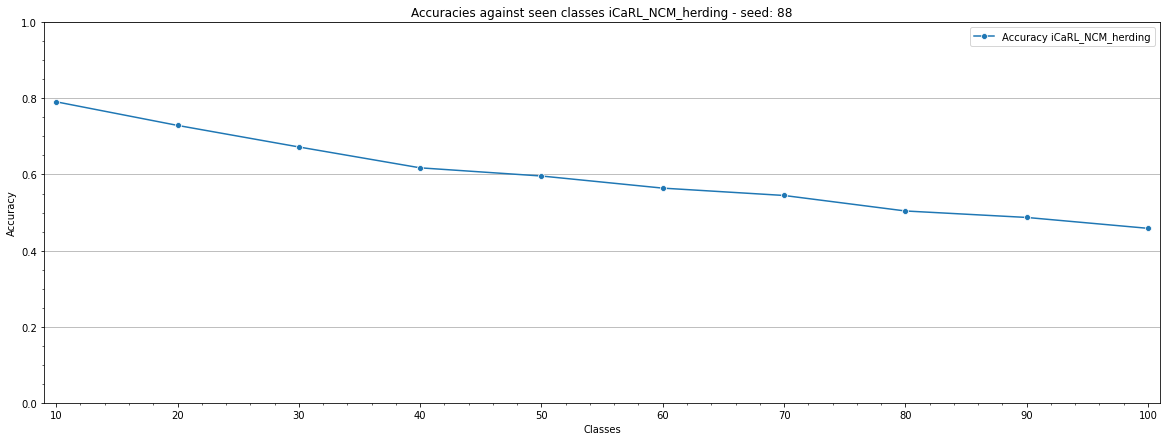

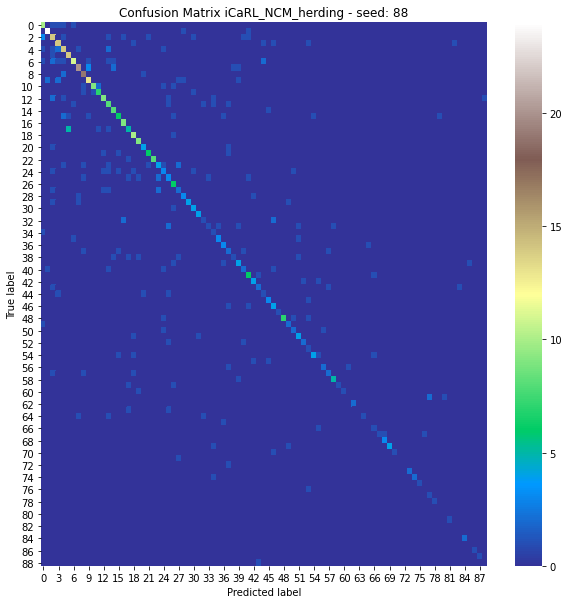

In [0]:
if herding:
  method = 'iCaRL_{}_herding'.format(classifier)
else:
  method = 'iCaRL_{}_random'.format(classifier)


print("metrics iCaRL for seed {}".format(RANDOM_SEED))

# accuracy 
data_plot_line=[]

classes_per_group = 10
for group_classes in range(0,10):
    data_plot_line.append(((group_classes + 1)*classes_per_group, accuracies[group_classes]))

# plot accuracy trend
utils.plotAccuracyTrend(method, data_plot_line, RANDOM_SEED)

# confusion matrix
confusionMatrixData = confusion_matrix(all_labels_cm, all_preds_cm)
utils.plotConfusionMatrix(method, confusionMatrixData, RANDOM_SEED)

# write to JSON file
utils.writeMetrics(method, RANDOM_SEED, accuracies, confusionMatrixData)